# 05 Logistic Regression

## Perform the following tasks

### Using the high-level OverFeat features

- Create a logistic regression estimator with an optional PCA preprocessing step.
- Tune the regularization strength and the number of components using grid search with cross-validation. Try with and without PCA.
- Collect the results in a DataFrame, print the best parameters and evaluate the test accuracy.

### Using your tuned estimator

- Pick ten images from the test set and print the class probabilities.
- Try with different regularization strengths. Write your observations.

## Load data

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import random

In [3]:
# Load the data form the .npz
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())
# Overview of the data content    
print('Data keys {}'.format(cifar4.keys()))

Data keys dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [4]:
# Generate the features matrices with pixels and overfeat
# Create X/y arrays
Xo = cifar4['overfeat']
Xp = cifar4['pixels']
y = cifar4['labels']
names = cifar4['names']

In [5]:
# Partition data set to be able to assess model performance and over/under fitting issues
from sklearn.model_selection import train_test_split

# Split data into train/test sets and insure balanced data sets (stratify)  
# Include pixels data set split for image part of exercise
Xo_train, Xo_test, y_train, y_test, Xp_train, Xp_test, label_train, label_test = train_test_split(
    Xo, y, Xp, y, train_size=4000, test_size=1000, random_state=0, stratify=y) #-> I have a doubt here:
# I stratitfy here despite I know in the GridSearchCV there is by default the StratifiedKFold,
# then I ensure first train /test sets to be balanced, and continue with a balanced CV over
# the train set. Is it right ?

#print ('Size of Xo_train, y_train :', Xo_train.shape, y_train.shape)
#print ('Size of Xo_test, y_test :', Xo_test.shape, y_test.shape)
#print ('Size of Xp_train, label_train :', Xp_train.shape, label_train.shape)
#print ('Size of Xp_test, label_test :', Xp_test.shape, label_test.shape)

## Task 1

## Logistic Regression with Cross Validation

Our data set has a lot of features. It means the classifier could tend to overfit.
To prevent this one will use a PCA as preprocessing step to reduce dimentionality and then the number of features.

In [6]:
# Create a logistic regression estimator with stochastic gradient descent (SGD)
sgdc = SGDClassifier(
    # Set logistic loss
    loss='log',
    # Set max number of iterations and stopping criteria
    max_iter=1000, tol=1e-3, random_state=0
)
# Create a PCA object
# From data exploration stage one knows that with 162 and 387 first components 90-95%
# of variance is explained
pca = PCA() # start with an empty object
# Create a pipeline with a scaler & PCA steps to be assessed if better with or not
pipe = Pipeline([
    #('scaler', StandardScaler()), # to test with/without
    ('pca', None),
    ('sgdclass', sgdc)
])

### Grid search CV

In [7]:
# Define a set of values
alphas = np.logspace(-3, 1, num=5) #alphasl={0.001,0.01,0.1,1,10}
n_compo = np.arange(160, 285,25) # 160, 185, .., 260

# Define the grid of parameters and values to assess
complex_grid = [
    # 1st grid
    {'sgdclass__alpha': alphas},
    # 2nd grid : PCA n_components tuning
    {'pca': [PCA()],
     'pca__n_components': n_compo,
     'sgdclass__alpha': alphas   
}]

In [9]:
# Create cross-validation object
grid_cv = GridSearchCV(pipe, complex_grid, cv=5, n_jobs=-1)

# Fit estimator
grid_cv.fit(Xo_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', None), ('sgdclass', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'sgdclass__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])}, {'pca': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'pca__n_components': array([160, 185, 210, 235, 260]), 'sgdclass__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [12]:
# Print the number of combinations
print('Number of combinations:', len(grid_cv.cv_results_['params']))

Number of combinations: 30


### Score dataframe & best results

In [13]:
# Overview of all the keys names
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_sgdclass__alpha', 'param_pca', 'param_pca__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [14]:
# Create a df with all the desired results for the differents C
df_sgdc_results = pd.DataFrame(grid_cv.cv_results_)[['param_sgdclass__alpha', 
                                                'mean_test_score', 
                                                'std_test_score',
                                                'mean_train_score',
                                                'std_train_score',
                                                'param_pca__n_components'
                                                      ]]
#filter= df_sgdc_results['param_pca__n_components'] > 0
#df_sgdc_results[~filter].sort_values(by=['param_sgdclass__alpha', 'param_pca__n_components'], ascending= False).head(30)
df_sgdc_results.sort_values(by='mean_test_score', ascending= False).head()

,param_sgdclass__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score,param_pca__n_components
2,0.1,0.83375,0.016602,0.911938,0.007980,NaN
25,0.001,0.83275,0.011219,0.878438,0.004949,260
15,0.001,0.83125,0.015431,0.874875,0.004077,210
21,0.01,0.83050,0.010050,0.871875,0.002809,235
20,0.001,0.82900,0.016458,0.878250,0.002259,235


In [15]:
# Print out the best configuration and score on validation set 
sgdc_idx = df_sgdc_results['mean_test_score'].idxmax()
print ('Top accuracy across folds: {:.4f} (std: {:.3f}) with n_components = {}, and alpha: {:.4f}'
       .format(df_sgdc_results.loc[sgdc_idx,'mean_test_score'],
               df_sgdc_results.loc[sgdc_idx,'std_test_score'],
               df_sgdc_results.loc[sgdc_idx,'param_pca__n_components'],
               df_sgdc_results.loc[sgdc_idx,'param_sgdclass__alpha']))

Top accuracy across folds: 0.8337 (std: 0.017) with n_components = nan, and alpha: 0.1000


In [17]:
# Evaluate the test accuracy
acc_test= grid_cv.score(Xo_test, y_test)
print ('Logistic regression accuracy (test set): {:.4f}'.format(acc_test))

Logistic regression accuracy (test set): 0.8330


## Task 2

In [21]:
# Take 10 images from the test set and get their class probabilities
Rand_10 = random.sample(range(0, len(Xo_test)), 10)
# Use the attribute "best_estimator" to get best prediction
best_proba = grid_cv.best_estimator_.predict_proba(Xo_test[Rand_10])
# Store it in a df
df = pd.DataFrame(best_proba, columns=['truck','car','airplane','ship']).round(3)
df

,truck,car,airplane,ship
0,0.106,0.098,0.692,0.104
1,0.997,0.003,0.000,0.000
2,0.011,0.985,0.003,0.001
3,0.000,0.001,0.136,0.863
4,0.083,0.869,0.048,0.000
5,0.050,0.000,0.169,0.780
6,0.000,0.098,0.280,0.622
7,0.852,0.056,0.012,0.080
8,0.001,0.030,0.921,0.047
9,0.951,0.048,0.001,0.000


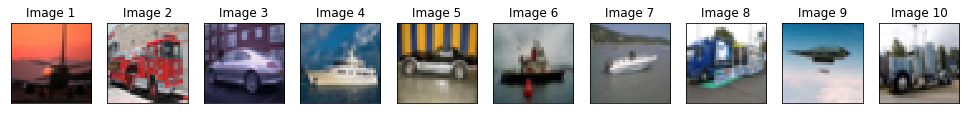

In [24]:
# Display the 10 random images
ten_ima = Xp_test[Rand_10]
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(17, 4))
for i,axis in enumerate(axes):
    flat_img = ten_ima[i,:]
    img = flat_img.reshape(32, 32, 3)
    axis.imshow(img)
    axis.get_xaxis().set_visible(False) 
    axis.get_yaxis().set_visible(False)
    axis.set_title('Image {}'.format(i+1))

plt.show()

In [34]:
# Analyse effect of regularization strenght on the probabilities
# Define a set of regularization strenght
alphas = np.logspace(-3, 1, num=5)
# Create list to store intermediary results
list_proba = []

for i, alpha in enumerate(alphas):
    sgdc = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=0, alpha=alpha)
    pca = PCA(n_components= 200)
    pipe = Pipeline([('pca', pca),('sgdclass', sgdc)])
    pipe.fit(Xo_train, y_train)
    proba = pipe.predict_proba(Xo_test[Rand_10])
    list_proba.append(proba)
    df_proba = pd.DataFrame(list_proba[i], columns=['truck','car','airplane','ship']).round(6)
    print('\nalpha = {}'.format(alpha))
    print(df_proba)

C:\Users\Joker\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



alpha = 0.001
   truck  car  airplane  ship
0    0.0  0.0       1.0   0.0
1    1.0  0.0       0.0   0.0
2    0.0  1.0       0.0   0.0
3    0.0  0.0       0.0   1.0
4    0.0  1.0       0.0   0.0
5    0.0  0.0       0.0   1.0
6    0.0  0.0       1.0   0.0
7    1.0  0.0       0.0   0.0
8    0.0  0.0       1.0   0.0
9    1.0  0.0       0.0   0.0

alpha = 0.01
   truck  car  airplane     ship
0    0.0  0.0   1.00000  0.00000
1    1.0  0.0   0.00000  0.00000
2    0.0  1.0   0.00000  0.00000
3    0.0  0.0   0.00000  1.00000
4    0.0  1.0   0.00000  0.00000
5    0.0  0.0   0.00000  1.00000
6    0.0  0.0   0.99315  0.00685
7    1.0  0.0   0.00000  0.00000
8    0.0  0.0   1.00000  0.00000
9    1.0  0.0   0.00000  0.00000

alpha = 0.1
      truck       car  airplane      ship
0  0.000000  0.000000  0.999769  0.000231
1  1.000000  0.000000  0.000000  0.000000
2  0.000019  0.999981  0.000000  0.000000
3  0.000000  0.000000  0.040703  0.959297
4  0.000047  0.999871  0.000082  0.000000
5  0.000000  

## Note:
When alpha increses it becomes less clear what class is the right one. From an alpha of 0.001 with only 0 or 1 as results, to an alpha of 10 with very low dominant values.

# Choice of the best algorithm

- It seems that Logistic Regression is the best.

In [42]:
# Load the test set
with np.load('cifar4-test.npz', allow_pickle=False) as npz_file:
    pred_data = dict(npz_file.items())
print (pred_data.keys())

# Select overfeat
Xo_pred = pred_data['overfeat']

dict_keys(['pixels', 'overfeat', 'allow_pickle'])


In [43]:
# Generate predictions use the attribute "best_estimator"
predictions = grid_cv.best_estimator_.predict(Xo_pred)
np.save('test-predictions.npy', predictions)
# Get an overview of the array
predictions

array([3, 3, 2, 3, 2, 3, 3, 3, 0, 2, 3, 0, 1, 1, 0, 2, 3, 1, 2, 3, 1, 0,
       1, 2, 3, 1, 2, 0, 2, 1, 0, 0, 2, 1, 3, 0, 1, 1, 1, 3, 1, 3, 0, 2,
       2, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1,
       3, 2, 0, 1, 3, 3, 3, 2, 3, 3, 0, 3, 3, 1, 3, 0, 2, 3, 1, 0, 2, 3,
       3, 2, 2, 1, 1, 0, 1, 2, 0, 1, 3, 1, 3, 2, 0, 3, 3, 3, 1, 2, 1, 3,
       0, 1, 1, 0, 3, 1, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 3, 0, 1, 1, 0, 1,
       0, 3, 2, 2, 2, 1, 1, 1, 0, 3, 3, 2, 1, 2, 3, 1, 1, 1, 1, 2, 0, 2,
       3, 0, 3, 0, 3, 2, 0, 2, 0, 1, 2, 1, 0, 3, 3, 3, 0, 3, 0, 3, 0, 2,
       1, 2, 2, 0, 0, 2, 1, 0, 1, 2, 3, 3, 1, 0, 3, 0, 1, 0, 3, 3, 1, 2,
       3, 0, 3, 0, 3, 0, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 3, 1, 1, 0, 0, 1,
       1, 3, 3, 2, 1, 0, 3, 3, 0, 1, 2, 0, 2, 3, 1, 3, 2, 0, 2, 3, 1, 3,
       1, 3, 3, 2, 1, 3, 2, 2, 2, 1, 2, 2, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3,
       1, 1, 1, 3, 3, 0, 1, 3, 0, 0, 0, 2, 1, 2, 2, 1, 0, 2, 1, 3, 3, 3,
       0, 3, 3, 1, 3, 1, 2, 1, 2, 2, 3, 2, 0, 3, 1,

In [44]:
# Create df
df = pd.DataFrame(predictions)
# Generate the .csv in the working directory
df.to_csv("file_path.csv")